### TCGA to CCLE mutation prediction: LASSO parameter range experiments, summary across all genes

Here, we're interested in training mutation status models on data from TCGA (human tumor samples) and testing on data from CCLE (cancer cell lines). This is similar to our other experiments where we hold out and evaluate on all data from a single cancer type, but now the "domains" are entire datasets rather than cancer types from the same dataset.

This script plots the summarized results of varying regularization strength (LASSO parameter) across all genes in our cancer driver gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_to_ccle'
    # cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_to_ccle_sgd'
)

# 'aupr' or 'auroc'
metric = 'aupr'

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.drop(columns=['cancer_type'], inplace=True)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)

print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(10224, 5)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2'
 'BCOR' 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A'
 'STK11' 'NOTCH1' 'STAG2' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC'
 'IDH2' 'VHL' 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1'
 'ABL1' 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1'
 'CDH1' 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2'
 'CASP8' 'SOX9' 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,gene,lasso_param,seed,fold,nz_coefs
0,TP53,500.0,1,0,15152
1,TP53,500.0,1,1,15170
2,TP53,500.0,1,2,15172
3,TP53,500.0,1,3,15164
4,TP53,750.0,1,0,15184


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, 'tcga_to_ccle')
perf_df.drop(columns=['holdout_cancer_type'], inplace=True)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(61344, 9)
['TP53' 'KDM5C' 'RB1' 'CIC' 'BRAF' 'JAK1' 'ARID2' 'CSF1R' 'NPM1' 'PBRM1'
 'MET' 'CDKN2A' 'NCOR1' 'FLT3' 'CREBBP' 'ALK' 'SMARCA4' 'FOXL2' 'NF2'
 'BCOR' 'NRAS' 'ERBB2' 'ARID1A' 'PDGFRA' 'AXIN1' 'MED12' 'SETBP1' 'KDM6A'
 'STK11' 'NOTCH1' 'STAG2' 'SMAD4' 'ARID1B' 'FGFR2' 'FBXW7' 'EGFR' 'APC'
 'IDH2' 'VHL' 'IDH1' 'EP300' 'ATRX' 'GNAS' 'SMAD2' 'CTNNB1' 'PTEN' 'DNMT1'
 'ABL1' 'PIK3CA' 'NOTCH2' 'FGFR3' 'GATA2' 'CARD11' 'KIT' 'ATM' 'ASXL1'
 'CDH1' 'BAP1' 'FUBP1' 'SF3B1' 'RNF43' 'NF1' 'NFE2L2' 'BRCA2' 'SETD2'
 'CASP8' 'SOX9' 'GNAQ' 'KRAS' 'JAK2' 'EZH2']


,auroc,aupr,gene,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,TP53,shuffled,1,train,0,tcga_to_ccle,5.0
1,0.53005,0.70010,TP53,shuffled,1,test,0,tcga_to_ccle,5.0
2,0.63588,0.59959,TP53,shuffled,1,cv,0,tcga_to_ccle,5.0
3,1.00000,1.00000,TP53,shuffled,1,train,1,tcga_to_ccle,5.0
4,0.50893,0.69558,TP53,shuffled,1,test,1,tcga_to_ccle,5.0


### Distribution of model sizes (number of nonzero coefficients)

In [5]:
coefs_perf_df = (nz_coefs_df
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(30672, 8)


,gene,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,TP53,500.0,1,0,15152,1.00000,1.00000,train
1,TP53,500.0,1,0,15152,0.86269,0.91768,test
2,TP53,500.0,1,0,15152,0.91133,0.88888,cv
3,TP53,500.0,1,1,15170,1.00000,1.00000,train
4,TP53,500.0,1,1,15170,0.85777,0.90817,test


Text(0.5, 0, 'Number of nonzero coefficients')

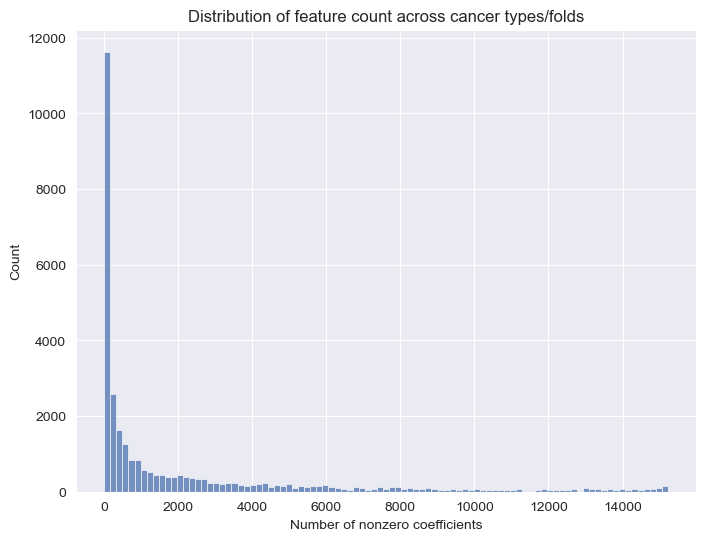

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero coefficients')

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal')]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2'))

['SETD2', 5.0, 0.1, 0.030128749999999982]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)
all_top_smallest_diff_df['best'] = 'top'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff < 0, 'best'
] = 'smallest'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff == 0, 'best'
] = 'zero'

print(all_top_smallest_diff_df.best.value_counts())
all_top_smallest_diff_df.head()

top         33
smallest    21
zero        17
Name: best, dtype: int64


,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
0,TP53,0.050,0.010,0.005441,top
1,KDM5C,10.000,0.050,0.030332,top
2,RB1,0.025,0.010,0.020917,top
3,CIC,0.050,0.025,0.005895,top
4,BRAF,0.100,0.050,0.014049,top


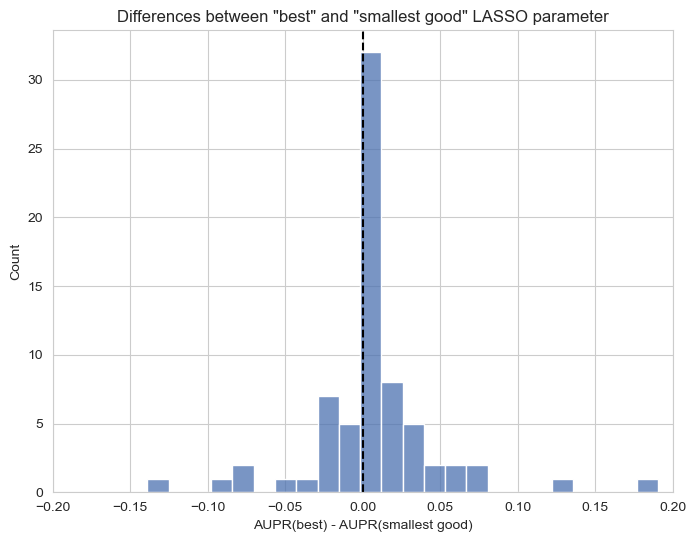

In [9]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(all_top_smallest_diff_df.top_smallest_diff, bins=24)
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" LASSO parameter')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

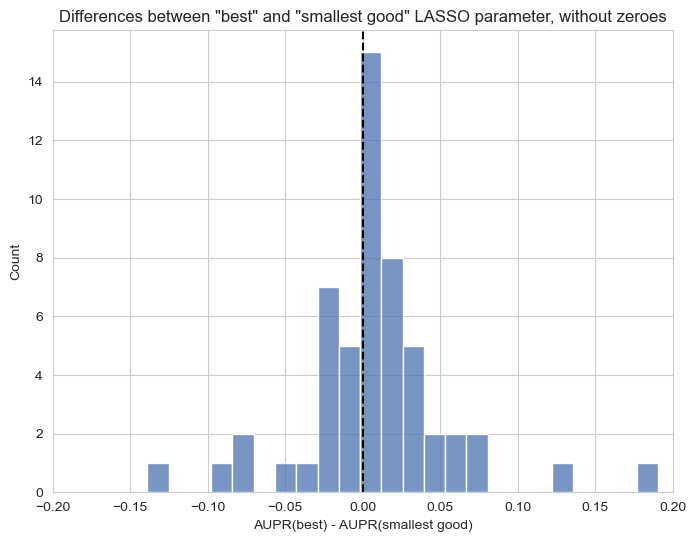

In [10]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(
    all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff,
    bins=24
)
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" LASSO parameter, without zeroes')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

In [11]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
16,SMARCA4,10.000,0.0100,0.190400,top
44,CTNNB1,5.000,0.1000,0.123941,top
6,ARID2,10.000,0.5000,0.072183,top
61,NF1,0.010,0.0025,0.069754,top
42,GNAS,0.005,0.0025,0.064116,top
45,PTEN,0.025,0.0100,0.054273,top
5,JAK1,0.250,0.0250,0.048905,top
53,KIT,0.025,0.0100,0.046286,top
65,CASP8,5.000,0.2500,0.035070,top
60,RNF43,0.025,0.0100,0.030512,top


In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
62,NFE2L2,0.050,0.010,-0.139007,smallest
57,BAP1,0.100,0.025,-0.090789,smallest
10,MET,0.010,0.005,-0.078025,smallest
46,DNMT1,0.025,0.010,-0.070949,smallest
28,STK11,0.025,0.010,-0.046479,smallest
32,ARID1B,500.000,0.010,-0.038149,smallest
31,SMAD4,0.050,0.025,-0.028493,smallest
56,CDH1,0.025,0.005,-0.028340,smallest
49,NOTCH2,250.000,5.000,-0.025544,smallest
11,CDKN2A,0.050,0.025,-0.024209,smallest


In [13]:
all_compare_df = []
for lasso_param in perf_df.lasso_param.unique():
    compare_df = au.compare_results(perf_df[perf_df.lasso_param == lasso_param],
                                    metric='aupr',
                                    data_type='cv',
                                    verbose=True,
                                    correction=True,
                                    correction_alpha=0.001)
    compare_df['lasso_param'] = lasso_param
    all_compare_df.append(compare_df)

all_compare_df = pd.concat(all_compare_df)

print(all_compare_df.shape)
print(all_compare_df.reject_null.value_counts())
all_compare_df.head()

(1278, 6)
True     676
False    602
Name: reject_null, dtype: int64


,identifier,delta_mean,p_value,corr_pval,reject_null,lasso_param
0,ABL1,0.033722,1.780361e-01,2.006439e-01,False,5.0
1,ALK,0.006343,6.185685e-01,6.471896e-01,False,5.0
2,APC,0.104789,2.067120e-06,3.835355e-06,True,5.0
3,ARID1A,0.324784,3.045832e-11,1.663493e-10,True,5.0
4,ARID1B,0.002976,7.557477e-01,7.665441e-01,False,5.0


In [14]:
top_compare_df = (all_compare_df
    .merge(all_top_smallest_diff_df.loc[:, ['gene', 'top_lasso_param']],
           left_on=['identifier', 'lasso_param'],
           right_on=['gene', 'top_lasso_param'])
    .drop(columns=['identifier', 'delta_mean', 'p_value', 'lasso_param'])
)

smallest_compare_df = (all_compare_df
    .merge(all_top_smallest_diff_df.loc[:, ['gene', 'smallest_lasso_param']],
           left_on=['identifier', 'lasso_param'],
           right_on=['gene', 'smallest_lasso_param'])
    .drop(columns=['identifier', 'delta_mean', 'p_value', 'lasso_param'])
)

top_smallest_compare_df = (top_compare_df
    .merge(smallest_compare_df,
           left_on=['gene'], right_on=['gene'])
    .rename(columns={
        'corr_pval_x': 'top_corr_pval',
        'reject_null_x': 'top_reject_null',
        'corr_pval_y': 'smallest_corr_pval',
        'reject_null_y': 'smallest_reject_null'
    })
)
top_smallest_compare_df['reject_either'] = (
    top_smallest_compare_df.top_reject_null | top_smallest_compare_df.smallest_reject_null
)
top_smallest_compare_df['reject_both'] = (
    top_smallest_compare_df.top_reject_null & top_smallest_compare_df.smallest_reject_null
)

print(top_compare_df.shape, smallest_compare_df.shape)
print(top_smallest_compare_df.reject_either.value_counts())
print(top_smallest_compare_df.reject_both.value_counts())
top_smallest_compare_df.head()

(71, 4) (71, 4)
True     54
False    17
Name: reject_either, dtype: int64
True     52
False    19
Name: reject_both, dtype: int64


,top_corr_pval,top_reject_null,gene,top_lasso_param,smallest_corr_pval,smallest_reject_null,smallest_lasso_param,reject_either,reject_both
0,3.725347e-01,False,ASXL1,5.0,5.364576e-01,False,0.50,False,False
1,2.322834e-09,True,CASP8,5.0,4.582260e-09,True,0.25,True,True
2,1.575671e-13,True,CTNNB1,5.0,2.801121e-15,True,0.10,True,True
3,1.705024e-01,False,EZH2,5.0,6.645485e-01,False,0.05,False,False
4,2.522785e-04,True,MED12,5.0,9.797428e-04,True,0.25,True,True


In [15]:
reject_both_genes = top_smallest_compare_df[top_smallest_compare_df.reject_both].gene.values
plot_df = (all_top_smallest_diff_df
    [all_top_smallest_diff_df.gene.isin(reject_both_genes)]
)

print(plot_df.shape)
print(plot_df.best.value_counts())
plot_df.head()

(52, 5)
top         28
smallest    16
zero         8
Name: best, dtype: int64


,gene,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
0,TP53,0.050,0.010,0.005441,top
1,KDM5C,10.000,0.050,0.030332,top
2,RB1,0.025,0.010,0.020917,top
3,CIC,0.050,0.025,0.005895,top
4,BRAF,0.100,0.050,0.014049,top


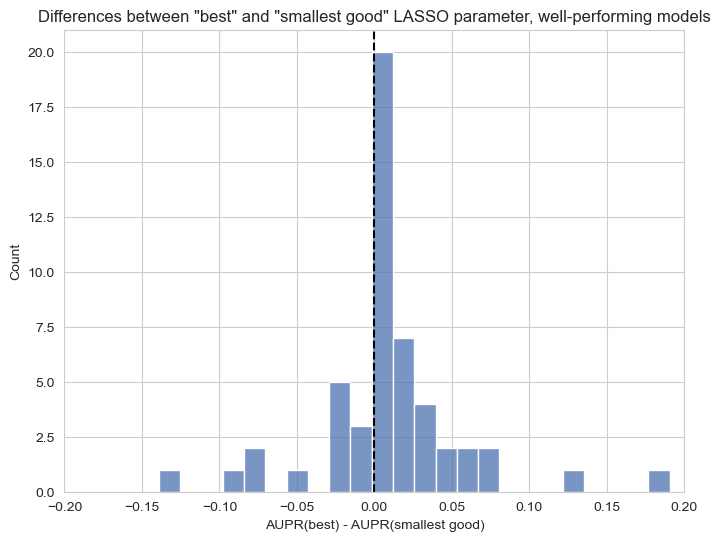

In [16]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(
    plot_df.top_smallest_diff, bins=24
)
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" LASSO parameter, well-performing models')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

### Compare TCGA and CCLE performance for each gene

Given the "best" LASSO parameter (in terms of validation performance) for each gene, we want to look at relative performance on the TCGA validation set and on the held-out CCLE data.

We expect there to be some genes where we can predict mutation status well both within TCGA and on CCLE (both "cv" and "test" performance are good), some genes where we can predict well on TCGA but we can't transfer our predictions to CCLE ("cv" performance is decent/good and "test" performance is poor), and some genes where we can't predict well on either set (both "cv" and "test" performance are poor).

In [17]:
cv_perf_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
).copy()
cv_perf_df.lasso_param = cv_perf_df.lasso_param.astype(float)

print(cv_perf_df.shape)
cv_perf_df.head()

(10224, 7)


,auroc,aupr,gene,seed,data_type,fold,lasso_param
2,0.85904,0.82567,TP53,42,cv,0,0.0025
5,0.85741,0.80355,TP53,42,cv,1,0.0025
8,0.85974,0.81353,TP53,42,cv,2,0.0025
11,0.85662,0.81871,TP53,42,cv,3,0.0025
2,0.90009,0.85243,TP53,42,cv,0,500.0000


In [18]:
test_perf_df = (
    perf_df[(perf_df.data_type == 'test') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
).copy()
test_perf_df.lasso_param = test_perf_df.lasso_param.astype(float)

print(test_perf_df.shape)
test_perf_df.head()

(10224, 7)


,auroc,aupr,gene,seed,data_type,fold,lasso_param
1,0.84731,0.89941,TP53,42,test,0,0.0025
4,0.84075,0.89512,TP53,42,test,1,0.0025
7,0.84197,0.89451,TP53,42,test,2,0.0025
10,0.83208,0.89123,TP53,42,test,3,0.0025
1,0.86433,0.92399,TP53,42,test,0,500.0000


In [19]:
# get performance using "best" lasso parameter, across all seeds and folds
# (so we can plot the distribution/visualize the variance across CV splits)
best_perf_df = (
    all_top_smallest_diff_df.loc[:, ['gene', 'top_lasso_param']]
      .merge(cv_perf_df,
             left_on=['gene', 'top_lasso_param'],
             right_on=['gene', 'lasso_param'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'cv_auroc',
                       'aupr': 'cv_aupr'})
      .merge(test_perf_df,
             left_on=['gene', 'top_lasso_param', 'seed', 'fold'],
             right_on=['gene', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'test_auroc',
                       'aupr': 'test_aupr'})
)
best_perf_df['cv_test_auroc_diff'] = (
    best_perf_df.cv_auroc - best_perf_df.test_auroc
)
best_perf_df['cv_test_aupr_diff'] = (
    best_perf_df.cv_aupr - best_perf_df.test_aupr
)

print(best_perf_df.shape)
best_perf_df.sort_values(by='cv_test_aupr_diff', ascending=False).head()

(568, 12)


,gene,top_lasso_param,cv_auroc,cv_aupr,seed,data_type_x,fold,test_auroc,test_aupr,data_type_y,cv_test_auroc_diff,cv_test_aupr_diff
312,IDH1,10.0,0.99150,0.99788,42,cv,0,0.36782,0.15805,test,0.62368,0.83983
314,IDH1,10.0,0.98935,0.99706,42,cv,2,0.38506,0.16053,test,0.60429,0.83653
317,IDH1,10.0,0.94053,0.97991,1,cv,1,0.35057,0.14692,test,0.58996,0.83299
316,IDH1,10.0,0.96480,0.99082,1,cv,0,0.37931,0.15969,test,0.58549,0.83113
318,IDH1,10.0,0.94038,0.97378,1,cv,2,0.36782,0.15896,test,0.57256,0.81482


In [20]:
plot_df = (best_perf_df
    .drop(columns=['cv_test_auroc_diff', 'cv_test_aupr_diff', 'cv_auroc', 'test_auroc'])
    .melt(id_vars=['gene', 'top_lasso_param', 'seed', 'fold'],
          value_vars=['cv_aupr', 'test_aupr'],
          var_name=['dataset_metric'])
)
plot_df.head()

,gene,top_lasso_param,seed,fold,dataset_metric,value
0,TP53,0.05,1,0,cv_aupr,0.90872
1,TP53,0.05,1,1,cv_aupr,0.89348
2,TP53,0.05,1,2,cv_aupr,0.89253
3,TP53,0.05,1,3,cv_aupr,0.89992
4,TP53,0.05,42,0,cv_aupr,0.89267


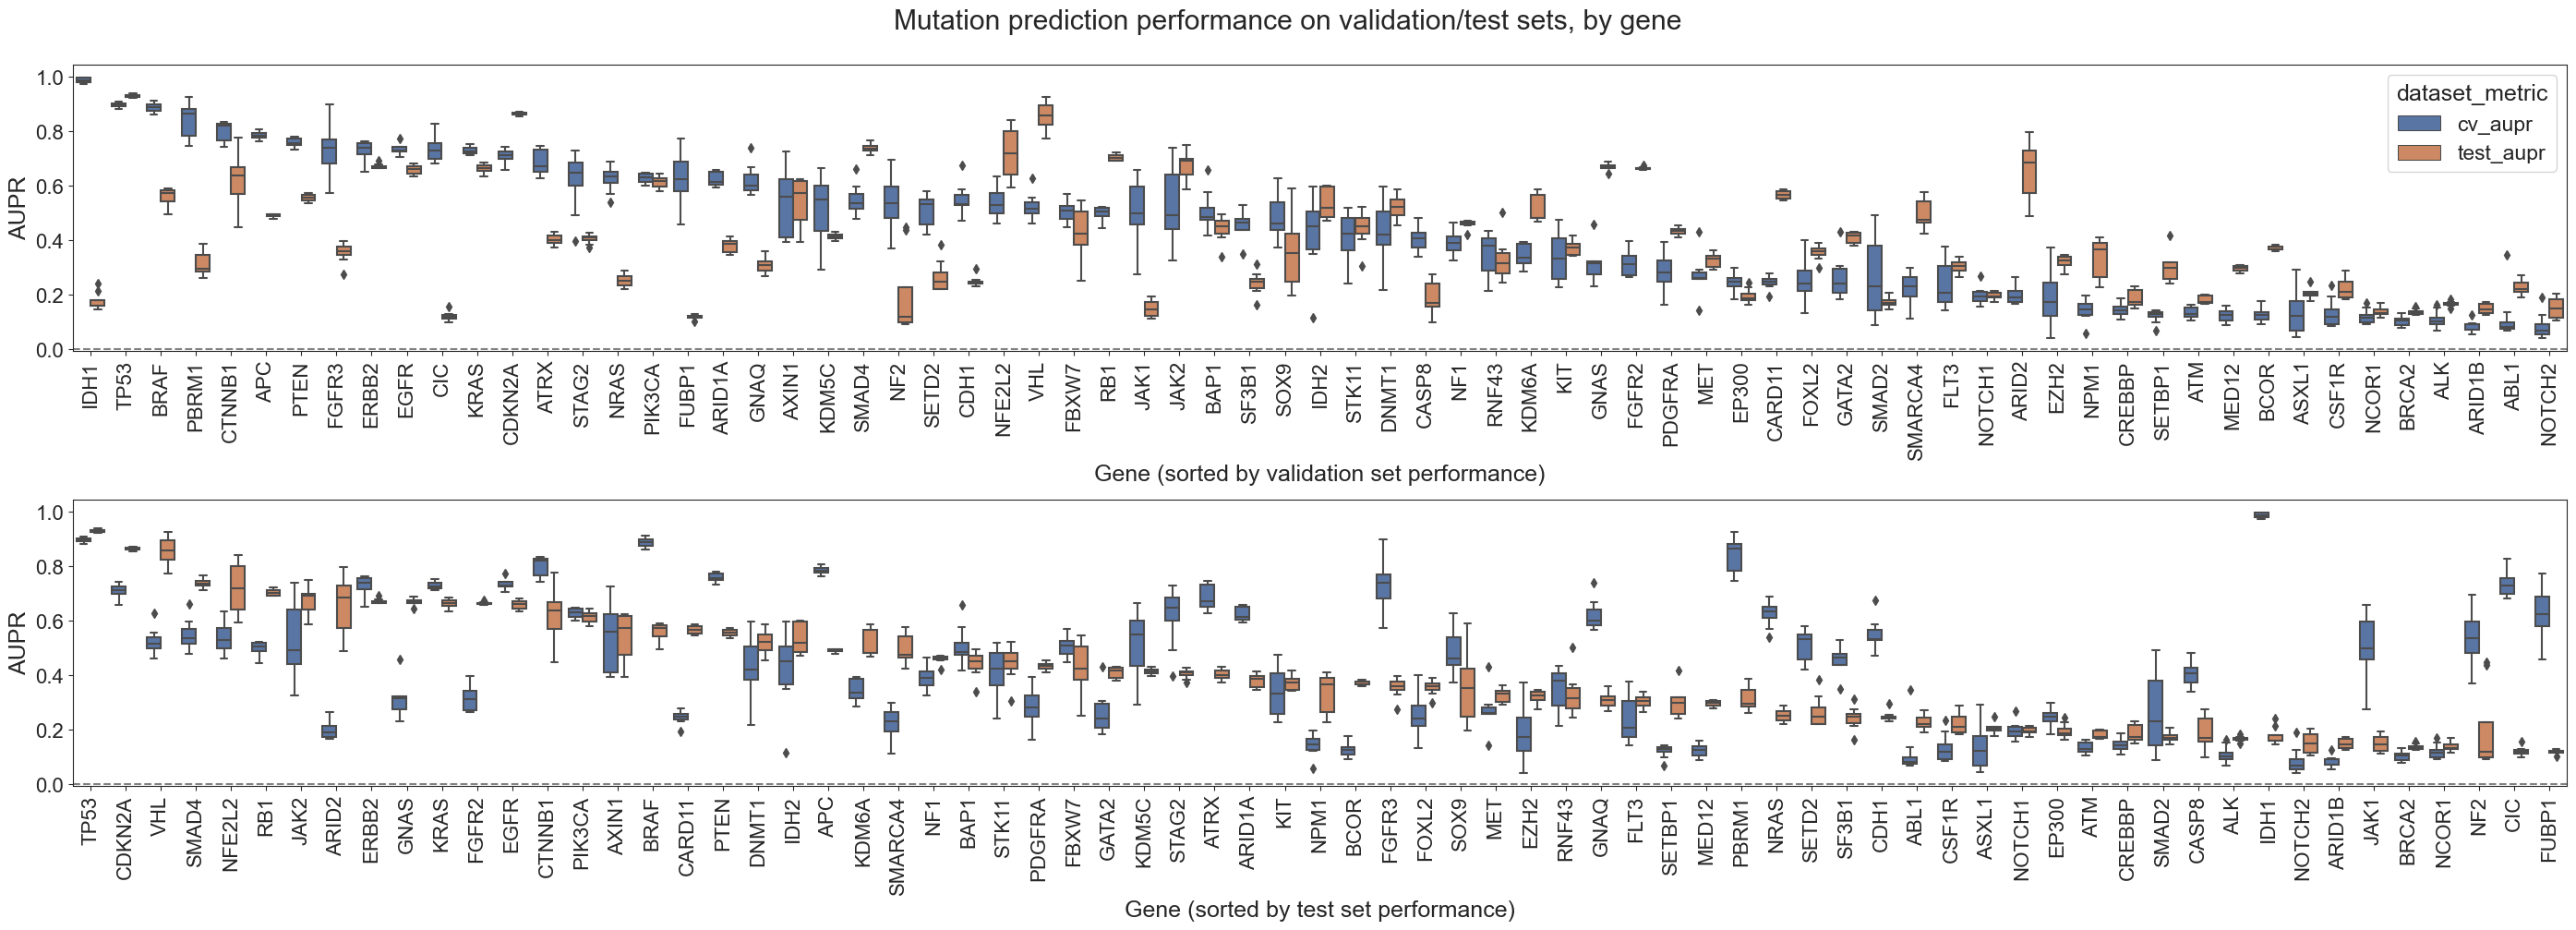

In [21]:
# plot cv/test performance distribution for each gene
sns.set({'figure.figsize': (28, 10)})
sns.set_style('ticks')

fig, axarr = plt.subplots(2, 1)

# order boxes by cv performance per gene
cv_gene_order = (plot_df[plot_df.dataset_metric == 'cv_aupr']
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='value', ascending=False)
).index.get_level_values(0).values

# order boxes by test performance per gene
test_gene_order = (plot_df[plot_df.dataset_metric == 'test_aupr']
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='value', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    sns.boxplot(data=plot_df, order=cv_gene_order,
                x='gene', y='value', hue='dataset_metric', ax=axarr[0])
    axarr[0].axhline(0.0, linestyle='--', color='grey')
    axarr[0].tick_params(axis='x', rotation=90, labelsize=16)
    axarr[0].tick_params(axis='y', labelsize=16)
    axarr[0].set_xlabel('Gene (sorted by validation set performance)', size=18)
    axarr[0].set_ylabel('AUPR', size=18)
    
    sns.boxplot(data=plot_df, order=test_gene_order,
                x='gene', y='value', hue='dataset_metric', ax=axarr[1])
    axarr[1].legend([], [], frameon=False)
    axarr[1].axhline(0.0, linestyle='--', color='grey')
    axarr[1].tick_params(axis='x', rotation=90, labelsize=16)
    axarr[1].tick_params(axis='y', labelsize=16)
    axarr[1].set_xlabel('Gene (sorted by test set performance)', size=18)
    axarr[1].set_ylabel('AUPR', size=18)
    
    plt.suptitle(f'Mutation prediction performance on validation/test sets, by gene', y=1.0025)
    
plt.tight_layout()

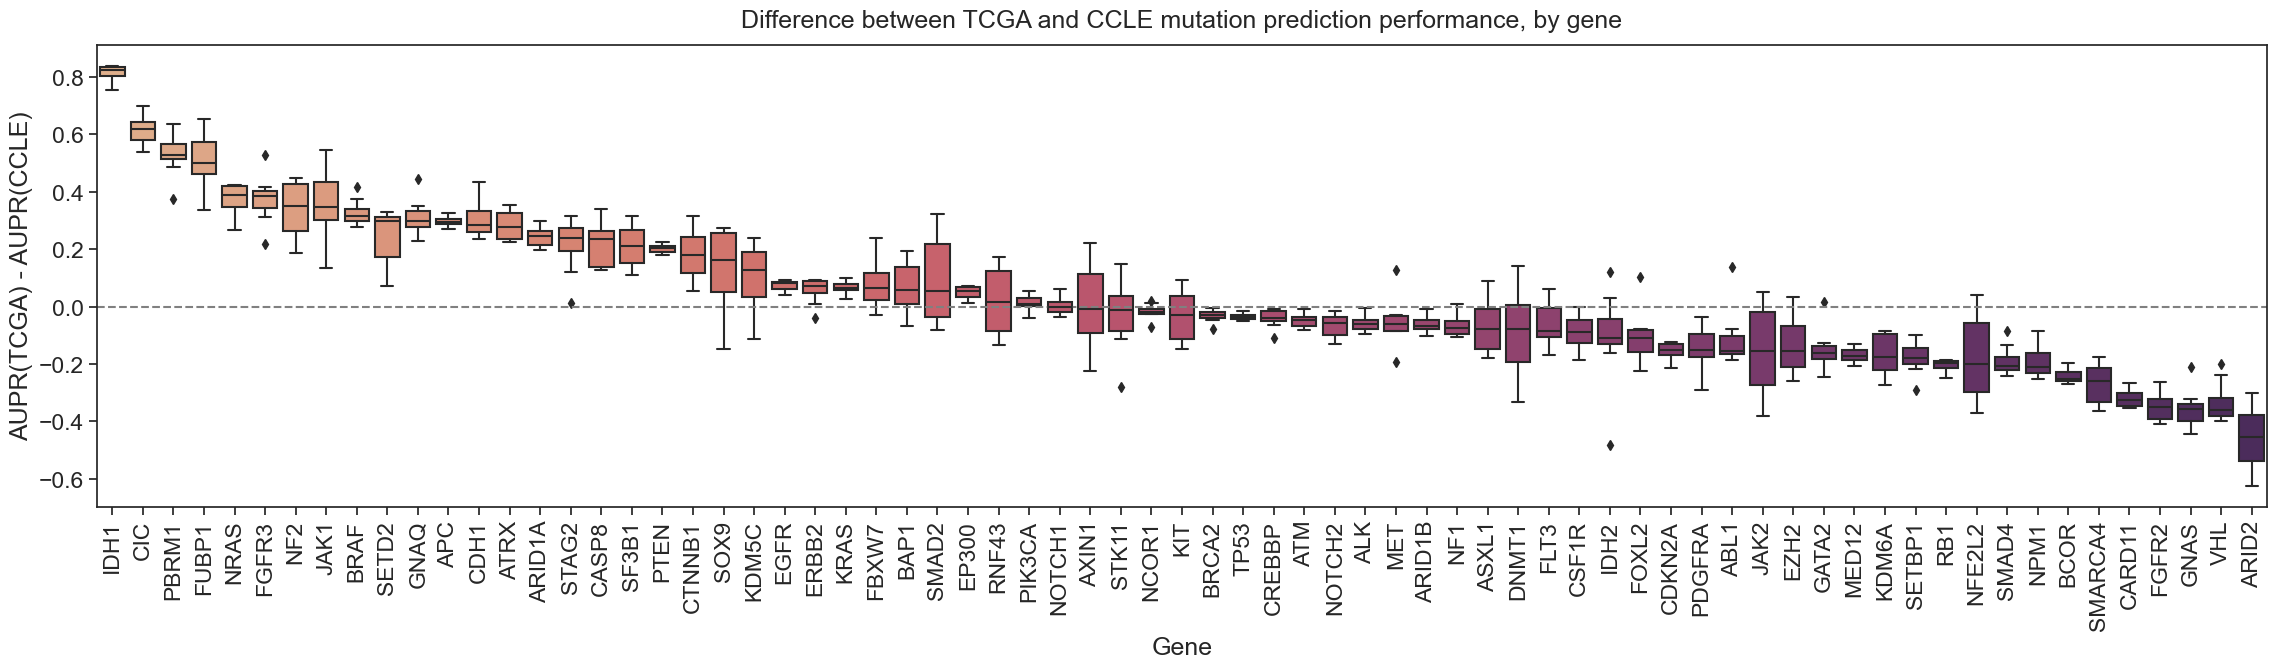

In [22]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median (cv - test) diff per gene
gene_order = (best_perf_df
    .groupby(['gene', 'top_lasso_param'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    ax = sns.boxplot(data=best_perf_df, order=gene_order,
                     x='gene', y='cv_test_aupr_diff',
                     palette='flare')
    ax.axhline(0.0, linestyle='--', color='grey')
    plt.xticks(rotation=90)
    plt.title(f'Difference between TCGA and CCLE mutation prediction performance, by gene', y=1.02)
    plt.xlabel('Gene')
    plt.ylabel('AUPR(TCGA) - AUPR(CCLE)')